#### We include a few other basic tools for filtering, tapering, and cleaning the data. Examples below: 

In [5]:

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

#-- To import a function on a relative path:
import sys
sys.path.append("../")
from pydas_readers.readers import load_das_h5
from pydas_readers.util import block_filters, block_cleaning


# Load Data

In [6]:
t_start = datetime.strptime('2023/02/06 01:17:34.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/06 01:17:54.0', '%Y/%m/%d %H:%M:%S.%f') 

#-- Load!
input_dir = "./example_data_Istanbul"

#-- This time we'll specify d_start and d_end (in meters), to zoom in on an interesting part of the data
data_raw, headers, axis = load_das_h5.load_das_custom(t_start, t_end, input_dir=input_dir, d_start=0, d_end=2000, verbose=False, convert=True)

t0 = headers['t0']
t1 = headers['t1']
lx = headers['lx']
fs = headers['fs']


# Example Pre-processing

In [7]:

#-- Detrend 
#--  Not usually needed for DAS data, but it's quite fast and good practice.
data_detrended = block_cleaning.detrend(data_raw, type='linear')

#-- Taper
#-- Either call directly with 
data_tapered = block_cleaning.taper(data_raw,0.02)
#--  or when filtering with "taper=0.02" (e.g., 2%)
 
    
#-- Bandpass Filter (and taper)
f1 = 10.0
f2 = 50.0
data_filtered = block_filters.block_bandpass(data_detrended, f1, f2, fs, zerophase=False, taper=0.02)
print("   Filtering completed")

#-- Trim: Pass new datetime objects and cut down the data block accordingly.
#--    "headers" dict must be passed and will be updated.
#--    "axis" object is optional, but will be updated if given.
#--    TODO: Instead of datetimes, design function to recognize relative seconds
#--    TODO: Add a trim option for distance axis instead of only time 
tc0 = datetime.strptime('2023/02/06 01:17:44.0', '%Y/%m/%d %H:%M:%S.%f')
tc1 = datetime.strptime('2023/02/06 01:17:49.0', '%Y/%m/%d %H:%M:%S.%f')
data_trim, headers_trim, axis_trim = block_cleaning.trim(data_filtered, tc0, tc1, headers, axis)


   Filtering completed


# Quick plot

In [12]:
#-- Define a plotting function

#-- (Easier to define such a function in-notebook rather than in a loaded function, 
#--    since updating labels or colorbars is easier)
plt.rcParams.update({'font.size': 14})
def waterfall(data,headers,axis,ax,vlim=0):

    #-- imshow data
    if(vlim==0):
        vlim = np.mean(np.abs(data))*10

    im = ax.imshow(data.T, aspect="auto", cmap='seismic', interpolation='antialiased', 
            extent=(0,headers["npts"]/headers["fs"], axis["dd"][-1]/1000,axis["dd"][0]/1000),
            vmin=-vlim, vmax=vlim)
    
    #-- y-axis
    ax.set_ylabel("Distance [km]")

    #-- Define the x-tick marks we want, format the labels
    x_timestamp_interval = 5 # seconds
    x_positions = np.arange(0, headers["npts"]/headers["fs"], x_timestamp_interval)  # time-samples
    x_labels_times = [None]*len(x_positions)
    for i,t in enumerate(x_positions):
        x_labels_times[i] = (headers['t0'] + timedelta(seconds=t)).strftime('%H:%M:%S')
    ax.set_xticks(x_positions, x_labels_times)
    ax.set_xlabel("Time (UTC)")

    if(headers['unit']=="(nm/m)/s"):
        #-- Because we used the flag, "convert=True" when reading, the units are physical.
        plt.colorbar(im,label="Strain-Rate [(nm/m)/s]",ax=ax)
    else:
        plt.colorbar(im,label="Optical Intensity",ax=ax)
 

    ax.set_title('Data on {0} GMT'.format(headers['t0'].strftime('%Y.%m.%d')))
    ax.invert_yaxis()
    return ax




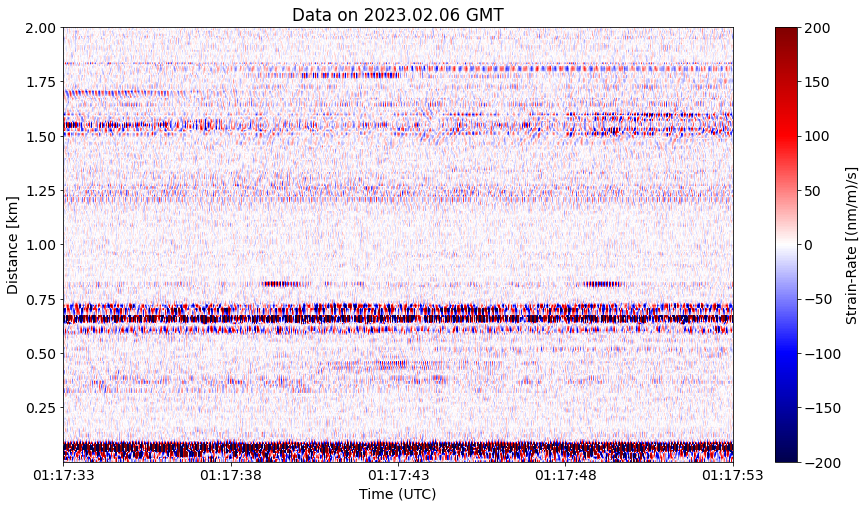

In [17]:

fig,ax = plt.subplots(figsize=(15,8))
ax = waterfall(data_trim,headers,axis,ax,vlim=200)


## BONUS: Know your filters! (Know what they're doing)

In [14]:
from scipy import signal

#############################################################################
## The butterworth filter that most seismologists use is fairly gentle.
## It surpresses frequencies outside the deired range but tapers them only slowly
## And the tapering starts OUTSIDE the range of interest, so your main frequencies are untampered with
f1 = 0.01
f2 = 10
fs = headers['fs']
data_filtered_butterworth = block_filters.block_bandpass(data_raw, f1, f2, fs, corners=8, zerophase=False)
# higher corners = sharper. So corners = 8 is sharper even than usual! Default is 4 for many programs.

#############################################################################
## In contrast the Chebyshev filter used in downsampling is quite sharp:
## We want to be absolutely certain that no frequencies exist above some limit, to avoid aliasing,
##  so it starts tapering BEFORE that limit
## (copied from downsample function)
rp, rs, order = 1, 96, 1e99
ws = f2 / (fs * 0.5)  # stop band frequency
wp = ws  # pass band frequency

while True:
    if order <= 12:
        break
    wp *= 0.99
    order, wn = signal.cheb2ord(wp, ws, rp, rs, analog=0)
sos = signal.cheby2(order, rs, wn, btype='low', analog=0, output='sos')
data_filtered_cheb = np.zeros( np.shape(data_raw) )

for i in range(np.shape(data_raw)[1]):
    data_filtered_cheb[:,i] = signal.sosfilt(sos, data_raw[:,i])


In [15]:
#-- We'll make a tool, to look at each spectra:

def amp_spectra(d,fs):
    """
    xf, spectra = amp_spectra(data[:,i], headers['fs'])
    
    Quick function to take an fft and compute x-axis of frequencies
    
    There's many ways to do this:
      - Use scipy functions
      - Use fft() and then roll() to get the correct part
      - Use rfft() 
    I also precompute NFFT as a power of 2, which is computationally better
     for Fortran and C. Probably this is unnecessary now with internal checks
     within numpy, but I wanted to be consistent.

    :param d: 1D numpy array
    :param fs: sample rate in Hz
    :return: xf, spectra
    """
    npts = len(d)
    delta = 1/fs
    nfft = (2.0**np.round(np.log2(npts))).astype(int)
    df = 1.0/(2*nfft*delta)
    xf = np.linspace(0.0, 1.0/(2.0*delta), int((nfft/2)+1))
    spectra = np.fft.rfft(d,n=nfft)
    return xf, spectra



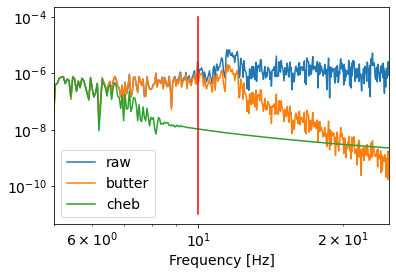

In [16]:
xf, spectra = amp_spectra(data_raw[:,200], headers['fs'])
plt.loglog(xf, np.abs(spectra)/1e9,  label='raw')

xf, spectra = amp_spectra(data_filtered_butterworth[:,200], headers['fs'])
plt.loglog(xf, np.abs(spectra)/1e9,  label='butter')

xf, spectra = amp_spectra(data_filtered_cheb[:,200], headers['fs'])
plt.loglog(xf, np.abs(spectra)/1e9,  label='cheb')

## Plot lines where the spectra is ostensibly filtered
plt.plot([f2,f2], [1e-11, 1e-4], 'r')
plt.xlim([5,25])
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

